In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [6]:
x_train = pd.read_csv("../data/processed/x_train.csv", index_col=0, dtype=str)
x_test = pd.read_csv("../data/processed/x_test.csv", index_col=0, dtype=str)
y_train = pd.read_csv(
  "../data/processed/y_train.csv", index_col=0, dtype=float
).squeeze("columns")
y_test = pd.read_csv(
  "../data/processed/y_test.csv", index_col=0, dtype=float
).squeeze("columns")

In [7]:
def get_correct_types_x(df, numeric_cols):
    for col in ['deenergize_time', 'restoration_time']:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
    return df
numeric_cols = [
    'hftd_tier', 'total_affected', 'residential_affected',
    'longitude', 'latitude', 'total_pop', 'median_age', 'median_income',
    'white_pct', 'tmin_d-4', 'tmax_d-4', 'wspd_d-4', 'tmin_d-3', 'tmax_d-3', 'wspd_d-3', 'tmin_d-2', 'tmax_d-2', 'wspd_d-2', 'tmin_d-1', 'tmax_d-1', 'wspd_d-1'
]
x_train = get_correct_types_x(x_train, numeric_cols)
x_test = get_correct_types_x(x_test, numeric_cols)
rel_x_train = x_train[numeric_cols]
rel_x_test = x_test[numeric_cols]

In [8]:
scaler = StandardScaler()
scaler.fit(rel_x_train)
scaled_train_x = scaler.transform(rel_x_train)
scaled_test_x = scaler.transform(rel_x_test)

We will look at three different error criteria: squared error, absolute error, and the reduction in Poisson deviation

In [9]:
param_grid = { 
    'n_estimators': [100, 200, 350, 500],
    'max_features': [1.0, 1 / 3, 'sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10],
    'criterion': ['squared_error', 'absolute_error', 'poisson']
}

In [10]:
rf = RandomForestRegressor(random_state=6)
rf_cv = RandomizedSearchCV(
    estimator=rf, param_distributions=param_grid, n_iter=int(0.2 * 240),
    cv=5, random_state=229,
)
rf_cv.fit(scaled_train_x, y_train)
preds = rf_cv.predict(scaled_test_x)

In [11]:
rf_cv.best_params_

{'n_estimators': 500,
 'max_features': 0.3333333333333333,
 'max_depth': 10,
 'criterion': 'squared_error'}

In [14]:
best_rf = RandomForestRegressor(
    n_estimators=500, max_features=(1 / 3), max_depth=10,criterion='squared_error', random_state=6
)
best_rf.fit(scaled_train_x, y_train)
best_preds = best_rf.predict(scaled_test_x)
permutation_res = permutation_importance(
    best_rf, scaled_test_x, y_test, n_repeats=10, random_state=24, n_jobs=2
)
rf_importance = pd.Series(permutation_res.importances_mean, index=numeric_cols)

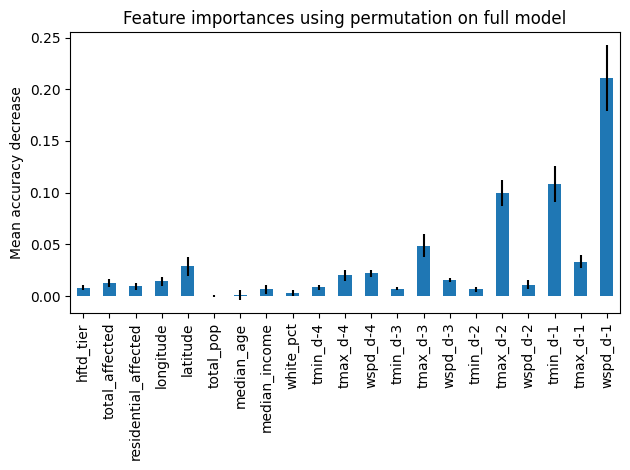

In [19]:
fig, ax = plt.subplots()
rf_importance.plot.bar(yerr=permutation_res.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [15]:
def calc_test_r2(pred_vals, true_vals, baseline_rmse):
    sse = mean_squared_error(pred_vals, true_vals) * len(true_vals)
    sst = (baseline_rmse ** 2) * len(true_vals)
    return 1 - sse / sst, np.sqrt(sse / len(true_vals))

In [16]:
baseline_rmse = np.sqrt(((y_test - y_test.mean()) ** 2).mean())
test_r2, rmse = calc_test_r2(preds, y_test, baseline_rmse)
print('Test R-Squared:', test_r2)
print('RMSE:', rmse)

Test R-Squared: 0.71859295853806
RMSE: 774.7653876738243
